In [1]:
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated, List
import operator
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from IPython.display import display, Image, Markdown
from langchain_core.messages import HumanMessage, SystemMessage
from pprint import pprint
from langfuse.callback import CallbackHandler

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0.2)
langfuse_handler = CallbackHandler()

In [2]:
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report")
    description: str = Field(description="Brief overview of the main topics and concentps to be covered in this section")

class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report.")

planner = llm.with_structured_output(Sections)


class State(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str

class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [5]:
def orachestrator(state: State):
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )
    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section"),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}")
        ]
    )
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    completed_sections = state["completed_sections"]
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report": completed_report_sections}

def assign_workers(state: State):
    return [Send("llm_call", {"section": s}) for s in state['sections']]



## Workflow

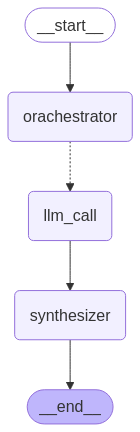

In [6]:
builder = StateGraph(State)

builder.add_node("orachestrator", orachestrator)
builder.add_node("llm_call", llm_call)
builder.add_node("synthesizer", synthesizer)

builder.add_edge(START, "orachestrator")
builder.add_conditional_edges("orachestrator", assign_workers, ["llm_call"])
builder.add_edge("llm_call", "synthesizer")
builder.add_edge("synthesizer", END)

workflow = builder.compile()
display(Image(workflow.get_graph().draw_mermaid_png()))

In [7]:
state = workflow.invoke({"topic": "write SWOT report about AirBnb"}, config={"callbacks": [langfuse_handler]})
Markdown(state["final_report"])

### Introduction and Description: Overview of Airbnb, Its Business Model, and the Purpose of the SWOT Analysis

Airbnb, founded in 2008, has revolutionized the hospitality industry by providing a platform that connects travelers with hosts offering unique accommodations around the world. The company was established with the vision of creating a global community where individuals could share their spaces and experiences, thus enabling travelers to find affordable and diverse lodging options beyond traditional hotels. Today, Airbnb operates in over 220 countries and regions, boasting millions of listings that range from spare rooms in urban apartments to entire villas in picturesque locations.

The business model of Airbnb is primarily based on a peer-to-peer marketplace, where hosts can list their properties on the platform, and guests can book these accommodations for short-term stays. Airbnb generates revenue by charging hosts a service fee for each booking, as well as a guest service fee, which varies based on the total cost of the reservation. This model not only allows for a wide variety of lodging options but also fosters a sense of community and local engagement, as guests often interact with hosts who can provide insider tips about the area.

The purpose of conducting a SWOT analysis (Strengths, Weaknesses, Opportunities, and Threats) for Airbnb is to evaluate its current position in the market and identify strategic avenues for growth and improvement. By analyzing the internal strengths and weaknesses alongside external opportunities and threats, stakeholders can gain insights into the competitive landscape and the potential challenges that may arise. This analysis will help Airbnb to leverage its strengths, address its weaknesses, capitalize on emerging opportunities, and mitigate potential risks, ultimately guiding the company towards sustainable growth and enhanced customer satisfaction in an ever-evolving travel industry.

---

### Strengths and Description

Airbnb has established itself as a formidable player in the hospitality and travel industry, leveraging several key strengths that contribute to its competitive advantage. This section analyzes the primary strengths of Airbnb, including its brand recognition, diverse offerings, and global reach.

#### Brand Recognition

One of Airbnb's most significant strengths is its strong brand recognition. Since its inception in 2008, Airbnb has become synonymous with short-term rentals and alternative accommodations. The company has successfully positioned itself as a trusted platform for travelers seeking unique lodging experiences, ranging from urban apartments to rural cabins. This brand equity is bolstered by extensive marketing campaigns, user-friendly technology, and a commitment to customer service, which have collectively fostered a loyal user base. As a result, Airbnb is often the first choice for travelers looking for accommodations outside traditional hotel offerings.

#### Diverse Offerings

Airbnb's diverse range of offerings is another critical strength. The platform caters to a wide variety of customer preferences and budgets, providing options that include entire homes, private rooms, shared spaces, and unique stays such as treehouses, yurts, and castles. This variety not only appeals to different segments of the market but also allows Airbnb to tap into niche markets, such as eco-tourism and luxury travel. Additionally, Airbnb has expanded its services to include experiences, allowing hosts to offer activities and tours, further enhancing the value proposition for users and creating additional revenue streams for the company.

#### Global Reach

Airbnb's global reach is a testament to its successful international expansion strategy. The platform operates in over 220 countries and regions, with millions of listings worldwide. This extensive network enables Airbnb to cater to a diverse clientele, accommodating travelers from various cultural backgrounds and preferences. The company's ability to adapt its offerings to local markets while maintaining a consistent brand experience has been instrumental in its growth. Furthermore, Airbnb's global presence allows it to capitalize on emerging travel trends and shifts in consumer behavior, positioning the company to respond effectively to market demands.

In summary, Airbnb's strengths in brand recognition, diverse offerings, and global reach not only enhance its competitive positioning but also contribute to its resilience in a rapidly evolving travel landscape. These strengths enable Airbnb to attract and retain customers, innovate its service offerings, and maintain a leadership role in the alternative accommodation market.

---

### Weaknesses

Despite its significant growth and market presence, Airbnb faces several weaknesses that could hinder its long-term sustainability and profitability. This section examines key areas of concern, including regulatory challenges, safety issues, and the company's dependency on hosts.

#### Regulatory Challenges

Airbnb operates in a complex regulatory environment that varies significantly across different regions and municipalities. Many cities have implemented strict regulations on short-term rentals to address concerns related to housing shortages, neighborhood disruption, and tax compliance. For instance, cities like New York and San Francisco have enacted laws that limit the number of days a property can be rented out or require hosts to register their properties with local authorities. These regulations can restrict Airbnb's operational flexibility and may lead to legal disputes, fines, or even bans in certain markets. As governments continue to scrutinize the short-term rental industry, Airbnb must navigate a patchwork of regulations that could impact its growth and profitability.

#### Safety Concerns

Safety is a paramount concern for both guests and hosts on the Airbnb platform. Incidents of property damage, theft, and even violent crimes have been reported, raising questions about the effectiveness of Airbnb's safety measures. Although the company has implemented various initiatives, such as a host guarantee program and a 24/7 customer support line, these measures may not fully alleviate safety concerns. High-profile incidents can lead to negative media coverage, damaging Airbnb's reputation and deterring potential users. Furthermore, the lack of standardized safety protocols across different listings can create inconsistencies in guest experiences, further complicating the company's efforts to build trust within its community.

#### Dependency on Hosts

Airbnb's business model is heavily reliant on its hosts, who provide the accommodations that drive the platform's success. This dependency presents several challenges. First, the quality and availability of listings can vary significantly, leading to inconsistent guest experiences. If hosts do not meet guest expectations, it can result in negative reviews and diminished customer loyalty. Additionally, the company faces the risk of host attrition, as some may choose to leave the platform due to dissatisfaction with Airbnb's policies, commission structures, or competition from other rental platforms. A decline in the number of active hosts could limit the variety of offerings available to guests, ultimately impacting Airbnb's market share and revenue.

In summary, while Airbnb has revolutionized the travel and hospitality industry, it must address these weaknesses to maintain its competitive edge and ensure long-term success. By proactively engaging with regulatory bodies, enhancing safety measures, and supporting its host community, Airbnb can work to mitigate these challenges and strengthen its position in the market.

---

### Opportunities and Description

As Airbnb continues to navigate the evolving landscape of the hospitality and travel industry, several key opportunities present themselves for market expansion, strategic partnerships, and technological advancements. These opportunities not only align with the company's core mission of creating a world where anyone can belong anywhere but also position Airbnb for sustained growth and innovation.

#### 1. Market Expansion

**Emerging Markets**: There is significant potential for Airbnb to expand its presence in emerging markets, particularly in regions such as Southeast Asia, Africa, and Latin America. These areas are witnessing a rise in domestic and international travel, driven by increasing disposable incomes and a growing middle class. By tailoring offerings to local preferences and cultural nuances, Airbnb can capture a larger share of these burgeoning markets.

**Long-term Rentals**: The demand for long-term rentals has surged, particularly in the wake of the COVID-19 pandemic, as remote work becomes more prevalent. Airbnb can capitalize on this trend by enhancing its long-term rental offerings, providing flexible lease options, and targeting digital nomads and remote workers seeking temporary housing solutions.

**Experiential Travel**: There is a growing consumer interest in experiential travel, where travelers seek authentic local experiences rather than traditional tourist activities. Airbnb can leverage its platform to promote unique experiences hosted by local residents, thereby enhancing its value proposition and differentiating itself from traditional hotel offerings.

#### 2. Strategic Partnerships

**Local Governments and Tourism Boards**: Collaborating with local governments and tourism boards can facilitate Airbnb's integration into communities, ensuring compliance with regulations while promoting tourism. Such partnerships can also enhance Airbnb's credibility and foster goodwill, leading to mutually beneficial initiatives that promote local attractions and events.

**Travel and Hospitality Brands**: Forming alliances with airlines, travel agencies, and hospitality brands can create synergies that enhance customer experiences. For instance, offering bundled packages that include flights, accommodations, and local experiences can attract a broader audience and streamline the booking process for travelers.

**Technology Providers**: Partnering with technology firms specializing in artificial intelligence, data analytics, and customer experience can enhance Airbnb's platform capabilities. By leveraging advanced technologies, Airbnb can improve its search algorithms, personalize user experiences, and optimize pricing strategies, ultimately driving higher conversion rates.

#### 3. Technological Advancements

**Enhanced User Experience**: Investing in user interface (UI) and user experience (UX) improvements can significantly enhance customer satisfaction. Features such as virtual reality tours of properties, AI-driven personalized recommendations, and seamless booking processes can attract and retain users.

**Blockchain Technology**: Exploring blockchain technology for secure transactions and transparent reviews can bolster trust within the platform. Implementing decentralized systems for identity verification and payment processing can enhance security and reduce fraud, making Airbnb a more attractive option for users.

**Sustainability Initiatives**: As consumers become increasingly environmentally conscious, Airbnb has the opportunity to lead in sustainability efforts within the travel industry. By developing features that promote eco-friendly accommodations and experiences, as well as implementing carbon offset programs, Airbnb can appeal to a growing demographic of environmentally aware travelers.

In conclusion, Airbnb stands at a pivotal moment where strategic market expansion, partnerships, and technological advancements can significantly enhance its competitive edge. By proactively pursuing these opportunities, Airbnb can not only solidify its position as a leader in the hospitality sector but also foster a more inclusive and sustainable travel ecosystem.

---

### Threats and Description

Airbnb operates in a dynamic and competitive landscape that presents several external threats that could impact its business model and market position. This section discusses key threats, including competition, economic downturns, and changing consumer preferences.

#### 1. Competition

The short-term rental market has become increasingly saturated, with numerous players vying for market share. Traditional hospitality companies, such as hotels and motels, are enhancing their offerings to compete with Airbnb by adopting more flexible pricing strategies and improving customer service. Additionally, new entrants into the market, including other peer-to-peer rental platforms like Vrbo and Booking.com, are continuously innovating and expanding their services. This heightened competition could lead to price wars, reduced market share, and increased marketing costs for Airbnb as it strives to maintain its competitive edge.

#### 2. Economic Downturns

Economic fluctuations pose a significant threat to Airbnb's business model. During periods of economic downturn, consumers tend to reduce discretionary spending, which can lead to a decline in travel and tourism. This reduction in demand for short-term rentals can adversely affect Airbnb's revenue and profitability. Furthermore, economic instability can lead to increased regulatory scrutiny and changes in local laws governing short-term rentals, which may impose additional operational challenges and costs for Airbnb hosts.

#### 3. Changing Consumer Preferences

Consumer preferences are continually evolving, influenced by factors such as technological advancements, societal shifts, and global events. The COVID-19 pandemic, for example, has significantly altered travel behaviors, with many consumers now prioritizing health and safety, remote work capabilities, and unique travel experiences. As a result, Airbnb must adapt its offerings to meet these changing demands, which may require substantial investment in technology and marketing. Failure to keep pace with consumer preferences could result in a loss of relevance and market share.

#### Conclusion

In summary, Airbnb faces a range of external threats that could impact its operations and growth trajectory. The competitive landscape is intensifying, economic downturns can lead to reduced demand, and shifting consumer preferences necessitate continuous adaptation. To mitigate these threats, Airbnb must remain agile, innovate its service offerings, and strategically navigate the challenges presented by the external environment.

---

### Conclusion and Description: Summary of the Findings from the SWOT Analysis and Strategic Recommendations for Airbnb's Future

The SWOT analysis conducted for Airbnb has provided valuable insights into the company's current position within the hospitality and travel industry. The findings highlight several key strengths, weaknesses, opportunities, and threats that will shape Airbnb's strategic direction moving forward.

**Strengths:**
Airbnb's primary strengths include its strong brand recognition, extensive global reach, and a diverse range of accommodation options that cater to various consumer preferences. The platform's user-friendly interface and robust community of hosts and guests further enhance its appeal, fostering trust and engagement within its marketplace.

**Weaknesses:**
Despite its strengths, Airbnb faces notable weaknesses, including regulatory challenges in various markets, which can hinder its operational flexibility. Additionally, concerns regarding safety, quality control, and customer service have been raised, potentially impacting user experience and brand loyalty. The company's reliance on a peer-to-peer model also exposes it to fluctuations in host availability and quality.

**Opportunities:**
The analysis identifies significant opportunities for Airbnb to expand its market presence. The growing trend of remote work and digital nomadism presents an avenue for Airbnb to promote long-term stays and work-friendly accommodations. Furthermore, the increasing demand for unique travel experiences can be leveraged through curated offerings and partnerships with local businesses. Expanding into new geographic markets, particularly in emerging economies, also presents a substantial growth opportunity.

**Threats:**
Airbnb must navigate various threats, including intense competition from traditional hospitality providers and other online travel agencies. Economic downturns and shifts in consumer behavior, particularly in the wake of global events such as the COVID-19 pandemic, pose additional risks. Furthermore, ongoing regulatory scrutiny and potential changes in legislation could impact Airbnb's operational model and profitability.

### Strategic Recommendations:
Based on the findings from the SWOT analysis, the following strategic recommendations are proposed for Airbnb's future:

1. **Enhance Regulatory Engagement:** Airbnb should proactively engage with local governments and regulatory bodies to advocate for fair regulations that support the sharing economy while addressing community concerns. Developing a robust compliance framework will help mitigate risks associated with legal challenges.

2. **Invest in Quality Assurance:** To address weaknesses related to safety and customer service, Airbnb should implement enhanced quality control measures, including host training programs and improved customer support systems. This will help build trust and ensure a consistent user experience.

3. **Diversify Offerings:** Expanding the range of services beyond traditional accommodations, such as offering experiences, guided tours, and local partnerships, can create additional revenue streams and enhance customer engagement. Promoting long-term stays and work-friendly spaces will also cater to the evolving needs of travelers.

4. **Leverage Technology:** Investing in technology to improve the user experience, such as AI-driven recommendations and personalized marketing strategies, can help Airbnb stay competitive. Additionally, utilizing data analytics to understand consumer behavior will enable more targeted offerings.

5. **Focus on Sustainability:** As consumers increasingly prioritize sustainability, Airbnb should enhance its commitment to eco-friendly practices. Initiatives such as promoting sustainable travel options and supporting local communities can strengthen brand loyalty and attract environmentally conscious travelers.

In conclusion, while Airbnb faces challenges in a dynamic market, its strengths and opportunities position it well for future growth. By addressing weaknesses and proactively managing threats, Airbnb can continue to innovate and lead in the evolving landscape of travel and hospitality.